<a href="https://colab.research.google.com/github/AdejokeOgundipe/Machine-Learning/blob/master/MachineLearningModelHub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


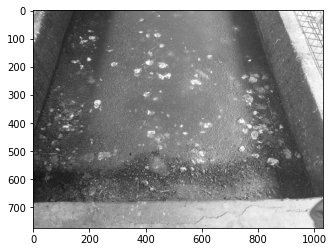

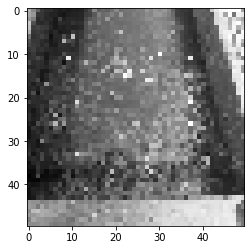

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2 
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint

import pickle
import time
DATADIR="/content/drive/My Drive/Colab Notebooks/Datasets/feces"

CATEGORIES = ["Healthy", "Unhealthy"]


for category in CATEGORIES:
  path = os.path.join(DATADIR, category)
  for img in os.listdir(path):
    img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
    plt.imshow(img_array, cmap ='gray')
    plt.show()
    break 
  break
#print(img_array.shape)
IMG_SIZE = 50 
new_array = cv2.resize(img_array,(IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap ='gray')
plt.show()

training_set =[]
def creating_training_dataset():
  for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
        new_array = cv2.resize(img_array,(IMG_SIZE, IMG_SIZE))
        training_set.append([new_array, class_num])
      except Exception as e:
        pass 
creating_training_dataset()


In [ ]:
#%load_ext tensorboard
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./log', histogram_freq=1, write_graph=True, write_images=True)

#NAME = "cats-and-dogs-{}".format(int(time.time()))
#tensorboard= TensorBoard(log_dir='logs/{}'.format(NAME))
#print(NAME)
#print(tensorboard)
#!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
#!unzip ngrok-stable-linux-amd64.zip
#NAME = "cats-and-dogs-{}".format(int(time.time()))
#tensorboard= TensorBoard(log_dir='logs/{}'.format(NAME))
#print(NAME)
#print(tensorboard)
#LOG_DIR = './log'
#get_ipython().system_raw(
 #   'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
  #  .format(LOG_DIR)
#)
#get_ipython().system_raw('./ngrok http 6006 &')

In [ ]:
#print(len(training_set))

In [ ]:
import random
random.shuffle(training_set)
for sample in training_set[:10]:
  print(sample[1])
x =[]
y=[]
for features,label in training_set:
  x.append(features)
  y.append(label)
x = np.array(x).reshape(len(training_set), IMG_SIZE, IMG_SIZE,1)
y = np.array(y)

import pickle
pickle_out = open("x.pickle","wb")
pickle.dump(x,pickle_out)
pickle_out.close()

pickle_out =open("y.pickle", "wb")
pickle.dump(y,pickle_out)
pickle_out.close()

pickle_in = open("x.pickle","rb")
x = pickle.load(pickle_in)



x = pickle.load(open("x.pickle","rb"))
y = pickle.load(open("y.pickle","rb"))


X = x/255.0

dense_layers = [0]
layer_sizes = [64]
conv_layers = [3]

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_sizes,dense_layer, int(time.time()))
            tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))
            print(NAME)
            model = Sequential()
            model.add(Conv2D(layer_size,(3,3), input_shape = X.shape[1:]))
            model.add(Activation("relu"))
            model.add(MaxPooling2D(pool_size=(2,2)))
            
            for l in range(conv_layer-1):
                model.add(Conv2D(layer_size,(3,3)))
                model.add(Activation("relu"))
                model.add(MaxPooling2D(pool_size=(2,2)))

                
            model.add(Flatten())
            for l in range(dense_layer):
                model.add(Dense(layer_size))
                model.add(Activation("relu"))

            model.add(Dense(1))
            model.add(Activation('sigmoid'))

            model.compile(loss='binary_crossentropy', 
                          optimizer='adam',
                          metrics=['accuracy'],)
                
                #checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_acc', verbose = 1, callbacks_list =[checkpoint])
            modelresult = model.fit(x,y, batch_size=32, verbose=1, 
                      epochs=10, validation_split=0.1, 
                      callbacks=[tensorboard])
            print(modelresult)
          


model.save('64x3-CNN.model')

      #tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./log', histogram_freq=1, write_graph=True, write_images=True)


In [ ]:
saved_model_dir = '/content/64x3-CNN.model'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()
tflite_model_file ="converted_model.tflite"

with open('tflite_model_file', 'wb') as f:
  f.write(tflite_model)

#labels = '\n'.join(sorted(train_generator.class_indices.keys()))
labels =['Healthy', 'Unhealthy']
with open('labels.txt', 'w') as f:
  f.write('\n'.join(labels))

INFO:tensorflow:Assets written to: /content/64x3-CNN.model/assets


In [ ]:
plt.plot(modelresult.history['accuracy'])
plt.plot(modelresult.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(modelresult.history['loss'])
plt.plot(modelresult.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
# serialize model structure to JSON
#model_json = model.to_json()
#with open("model_json", w) as json_file:
  #json_file.write(model_json)

try:
  from google.colab import files
  files.download('tflite_model_file')
  files.download('labels.text')

except:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Test the tflite model using the python interpreter
 
#interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
#interpreter.allocate_tensors()
 
#input_index = interpreter.get_input_details()[0]["index"]
#input_Index = interpreter.get_output_details()[0]["index"]
 
 
#predicts = []
#test_labels, test_imgs = [], []
#for img, label in test_set[:10]:
  #interpreter.set_tensor(input_index, img)
  #interpreter.invoke()
  #predictions.append(interpreter.get_tensor(output_index))
 
  #test_labels.append(Labels.nupy()[0])
  #test_img.apprend(img)
 
 
#prediction = model.predict(/content/drive/My Drive/Colab Notebooks/Datasets/Cats and dogs/cat-and-dog/test_set/test_set)

In [ ]:
import cv2
import tensorflow as tf

CATEGORIES =["Healthy","Unhealthy"]

def prepare(filepath):
  IMG_SIZE = 50
  img_array = cv2.imread(filepath,cv2.IMREAD_GRAYSCALE)
  new_array = cv2.resize(img_array,(IMG_SIZE, IMG_SIZE))
  return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1 )

model = tf.keras.models.load_model("64x3-CNN.model")
print(model)

prediction = model.predict([prepare('/content/images (2).jpeg')])
print(prediction)


[[0.02663893]]


In [ ]:
import cv2
import tensorflow as tf

CATEGORIES =["Healthy","Unhealthy"]

def prepare(filepath):
  IMG_SIZE = 50
  img_array = cv2.imread(filepath,cv2.IMREAD_GRAYSCALE)

  new_array = cv2.resize(img_array,(IMG_SIZE, IMG_SIZE))
  return new_array.reshape(-1, IMG_SIZE, IMG_SIZE,1 )

model = tf.keras.models.load_model("64x3-CNN.model")

prediction = model.predict([prepare('/content/images (2).jpeg')])

print(prediction)
print(CATEGORIES[int(prediction[0][0])])

[[0.02663893]]
Healthy


In [ ]:
#prediction = model.predict([prepare('/content/cornleave.jpg')])
prediction = model.predict([prepare('/content/test2.jpg')])
print(CATEGORIES[int(prediction[0][0])])

Unhealthy


In [ ]:
prediction = model.predict([prepare('/content/test.jpg')])
print(CATEGORIES[int(prediction[0][0])])

Healthy
